# Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. 

### Цель исследования

- Cпрогнозировать количество заказов такси на следующий час
* По условиям задачи значение метрики RMSE на тестовой выборке должно быть не больше 48.*

### Описание данных

- Исходный файл представляет из себя массив данных с количеством заказов такси за определенный промежуток времени.

- Количество заказов находится в столбце 'num_orders' (от англ. number of orders, «число заказов»).

### Ход исследования

Исследование будет проведено по следующему плану:
    
- **Подготовка**: Загрузка данных и их ресемплирование по одному часу.
- **Анализ**: Анализ полученных данных
- **Обучение**: Обучение разных моделей с различными гиперпараметрами. Формирование тестовой выборки размером 10% от исходных данных.
- **Тестирование**: Проверка данных на тестовой выборке и формулирование выводов.

## Подготовка

Для начала импортируем все необходимые библиотеки и загрузим датасет:

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

state = 12345

In [2]:
try:
    df = pd.read_csv('/Users/vladislav/Documents/datasets/taxi.csv', index_col=[0], parse_dates = [0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates = [0])

Необходимо изучить датасет, чтобы иметь представление о нем для дальнейшей работы:

In [3]:
display(df.head())
display(df.isna().sum())
display(df.describe())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


num_orders    0
dtype: int64

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


- В датасете всего 2 столбца с временным промежутком и количеством заказов такси. 
- Пропуски отсутствуют.
- Минимальные и максимальные значения не похожи на выбросы.

Убедимся, что данные расположены в хронологическом порядке:

In [4]:
print(df.index.is_monotonic)

True


Далее проведем ресэмплирование по 1 часу:

In [5]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


## Анализ

Построим график по полученным данным:

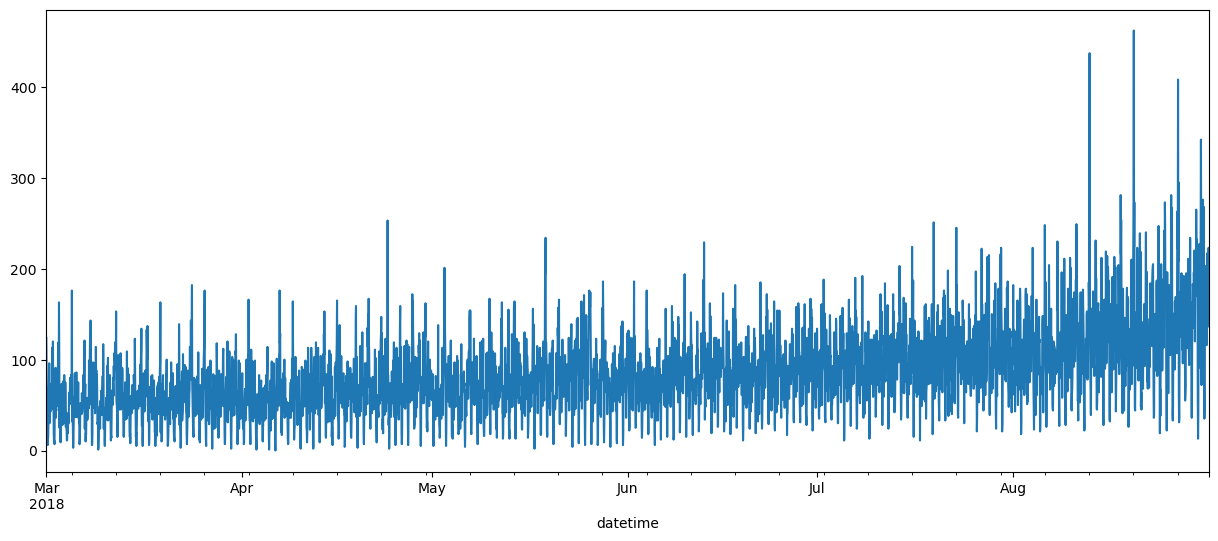

In [6]:
df['num_orders'].plot(figsize = (15,6))
plt.show()

Видно, что полученный временной ряд не является стационарным, потому что у него меняется среднее значение.

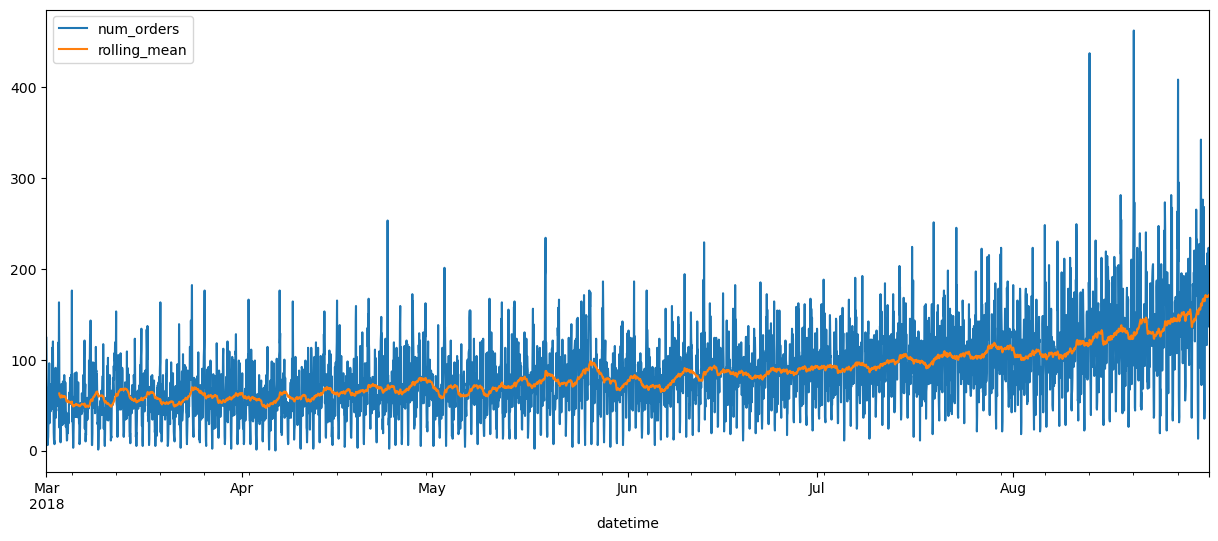

In [7]:
df['rolling_mean'] = df.rolling(50).mean()
df.plot(figsize = (15,6))
plt.show()
df = df.drop('rolling_mean', axis = 1)

По скользящему среднему видно, что число заказов такси в аэропортах остатется относительно низким в марте-
апреле, но в дальнейшем растет.
Далее в рамках анализа, можно разложить временной ряд на тренд и сезонную составляющую.

In [8]:
decomposed = seasonal_decompose(df)

Так как данные представлены за период нескольких месяцев в течении 1 года, месячную сезонность проанализировать нельзя, но можно изучить внутрисуточную и дневную сезонность.

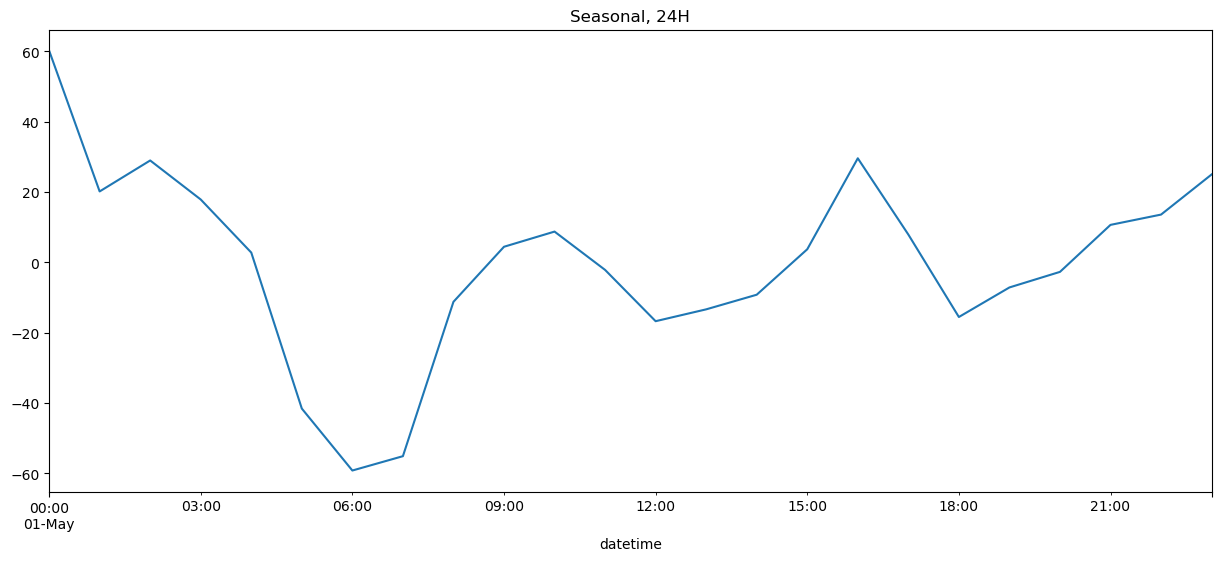

In [9]:
season = decomposed.seasonal
season['2018-05-01':'2018-05-01'].plot(ax = plt.gca(), title = 'Seasonal, 24H', figsize =(15,6))
plt.show()

По данному графику видно, что наибольшее число заказов на такси в аэропорту приходится на ночное время, когда не ходит общественный транспорт и достигает минимальных значений к 6 утра, когда транспорт начинает ходить (прим. аэроэкспресс в Московских аэропортах). В течении дня количество заказов относительно равномерно. 

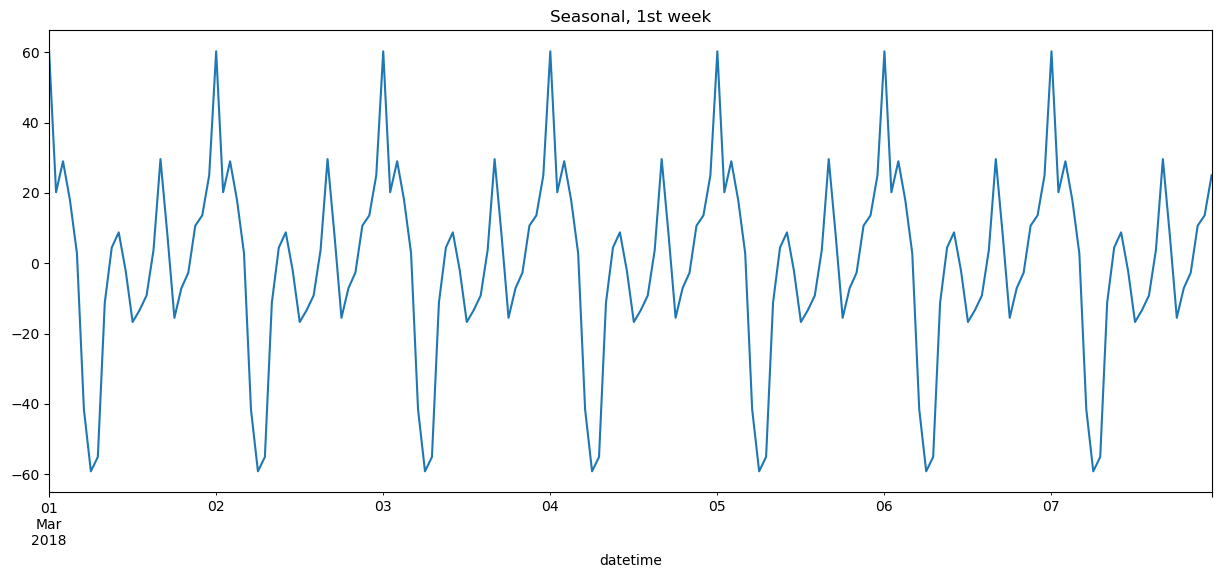

In [10]:
season = decomposed.seasonal
season.head(24*7).plot(ax = plt.gca(), title = 'Seasonal, 1st week', figsize =(15,6))
plt.show()

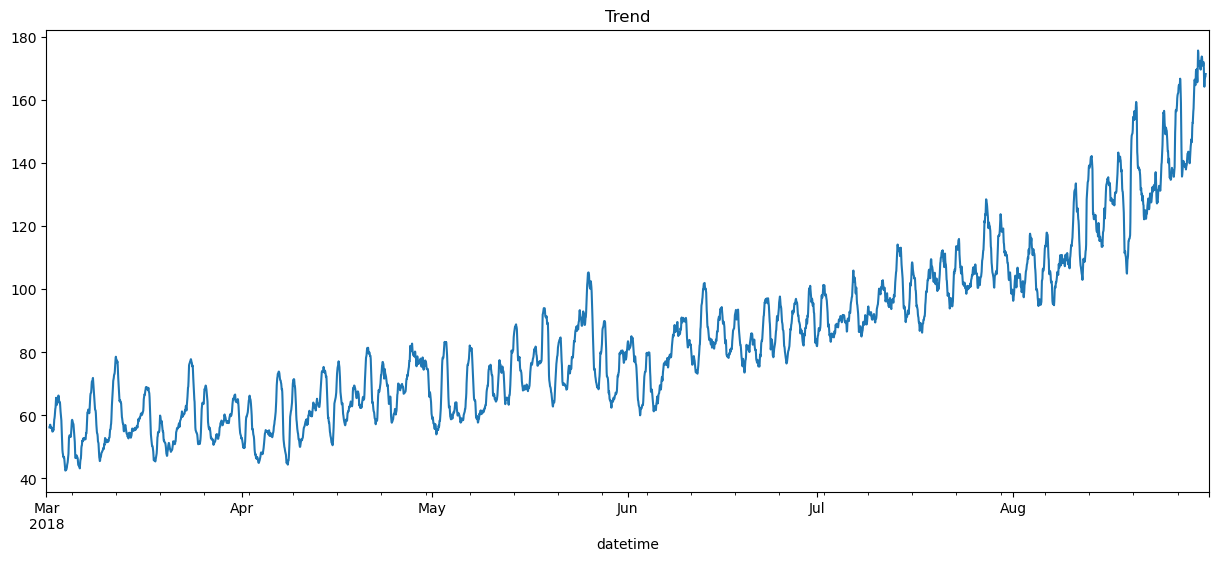

In [11]:
trend = decomposed.trend
trend.plot(ax = plt.gca(), title = 'Trend',figsize = (15,6))
plt.show()

Общий тренд также подтверждает, что число заказов растет за период наблюдения.

Для прогнозирования необходимо, чтобы ряд стал более стационарным. Для этого расчитаем разности временного ряда.

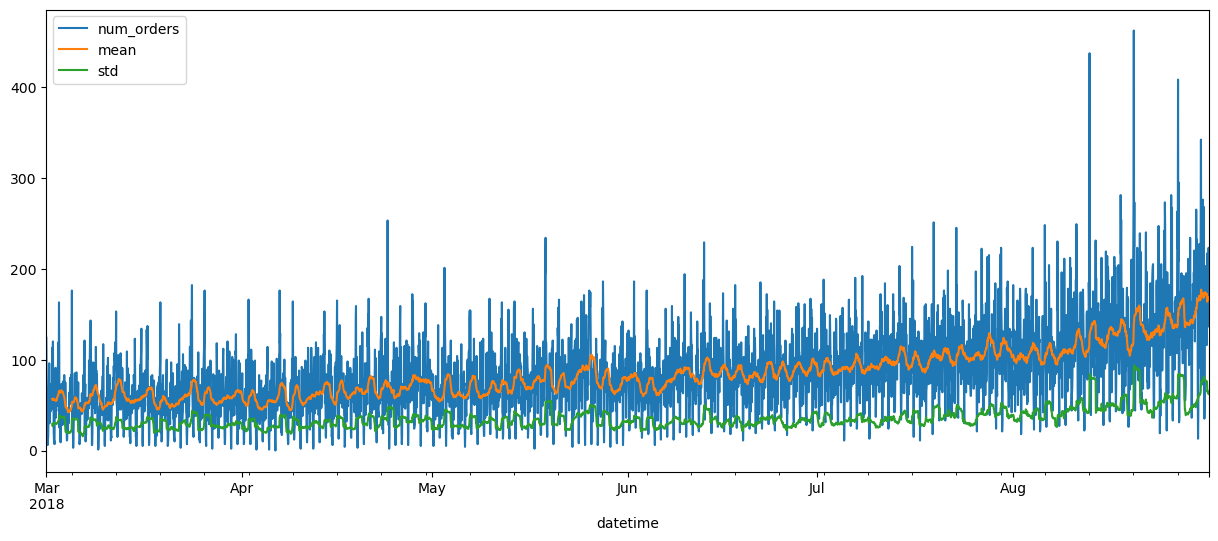

In [12]:
#df = df - df.shift()
df['mean'] = df['num_orders'].rolling(24).mean()
df['std'] = df['num_orders'].rolling(24).std()
df.plot(figsize = (15,6))
plt.show()

## Обучение

Для обучения необходимо создать признаки, для этого напишем функцию:

In [13]:
def make_features(data, max_lag, rolling_mean_size):
    #data['year'] = data.index.year
    #data['month'] = data.index.month
    data['day_of_week'] = data.index.dayofweek
    #data['day'] = data.index.day
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
        
    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()

In [14]:
make_features(df, 1, 24)

In [15]:
df.head(10)

,num_orders,mean,std,day_of_week,hour,lag_1,rolling_mean
datetime,,,,,,,
2018-03-01 00:00:00,124,NaN,NaN,3,0,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,3,1,124.0,NaN
2018-03-01 02:00:00,71,NaN,NaN,3,2,85.0,NaN
2018-03-01 03:00:00,66,NaN,NaN,3,3,71.0,NaN
2018-03-01 04:00:00,43,NaN,NaN,3,4,66.0,NaN
2018-03-01 05:00:00,6,NaN,NaN,3,5,43.0,NaN
2018-03-01 06:00:00,12,NaN,NaN,3,6,6.0,NaN
2018-03-01 07:00:00,15,NaN,NaN,3,7,12.0,NaN
2018-03-01 08:00:00,34,NaN,NaN,3,8,15.0,NaN


Удалим пропущенные значения:

In [16]:
df = df.dropna()

Далее необходимо разделить данные на обучающую и тестовую выборки.

In [17]:
train, test = train_test_split(df, shuffle = False, test_size = 0.1)

Проверим, что выборки разбились правильно и не перемешались:

In [18]:
print(train.index.min(), train.index.max())
print(test.index.min(), test.index.max())

2018-03-02 00:00:00 2018-08-13 15:00:00
2018-08-13 16:00:00 2018-08-31 23:00:00


In [19]:
features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

In [20]:
features_test = test.drop('num_orders', axis =1)
target_test = test['num_orders']

### Подбор параметров

In [21]:
tscv = TimeSeriesSplit()

#### Линейная регрессия

In [22]:
lr_parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}

In [23]:
lr_grid = GridSearchCV(LinearRegression(), param_grid = lr_parameters, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lr_grid.fit(features_train, target_train)

lr_best_parameters = lr_grid.best_params_
lr_model = LinearRegression(**lr_best_parameters)
lr_model.fit(features_train, target_train)

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)


  warnings.warn(
/Users/vladislav/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_base.py:141: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeli

LinearRegression(fit_intercept=False, normalize=True)

#### Random forest

In [24]:
rf_parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 20, 2),
        'verbose' : [-1],
        'random_state' : [state] 
        }

In [25]:
rf_grid = GridSearchCV(RandomForestRegressor(), param_grid = rf_parameters, refit=False, scoring='neg_mean_squared_error', cv=tscv)
rf_grid.fit(features_train, target_train)

rf_best_parameters = rf_grid.best_params_
rf_model = RandomForestRegressor(**rf_best_parameters)
rf_model.fit(features_train, target_train)

RandomForestRegressor(max_depth=19, random_state=12345)

#### LGBMRegressor

In [26]:
lgb_parameters = {
        'n_estimators' : range(50, 101, 10),
        'max_depth' : range(5, 20, 2),
        'verbose' : [-1],
        'random_state' : [state] 
        }

In [27]:
lgb_grid = GridSearchCV(LGBMRegressor(), param_grid = lgb_parameters, refit=False, scoring='neg_mean_squared_error', cv=tscv)
lgb_grid.fit(features_train, target_train)

lgb_best_parameters = lgb_grid.best_params_
lgb_model = LGBMRegressor(**lgb_best_parameters)
lgb_model.fit(features_train, target_train)

LGBMRegressor(max_depth=19, random_state=12345, verbose=-1)

## Тестирование

### Линейная регрессия

In [28]:
lr_test_pred = lr_model.predict(features_test)

print('Лучшие гиперпараметры: ', lr_best_parameters)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, lr_test_pred)**0.5)

Лучшие гиперпараметры:  {'copy_X': True, 'fit_intercept': False, 'normalize': True}
RMSE тестовой выборки:  43.59518754265869


### Random forest

In [29]:
rf_test_pred = rf_model.predict(features_test)

print('Лучшие гиперпараметры: ', rf_best_parameters)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, rf_test_pred)**0.5)

Лучшие гиперпараметры:  {'max_depth': 19, 'n_estimators': 100, 'random_state': 12345, 'verbose': 0}
RMSE тестовой выборки:  42.70814040057762


### LGBMRegressor

In [30]:
lgb_test_pred = lgb_model.predict(features_test)

print('Лучшие гиперпараметры: ', lgb_best_parameters)
print("RMSE тестовой выборки: ", mean_squared_error(target_test, lgb_test_pred)**0.5)

Лучшие гиперпараметры:  {'max_depth': 19, 'n_estimators': 100, 'random_state': 12345, 'verbose': -1}
RMSE тестовой выборки:  40.39705331704891


## Вывод

Был проведен анализ временного ряда по количеству заказываемых в аэропортах такси с марта по август 2018 года. По итогам анализа выяснилось:
- Количество заказов растет за наблюдаемый период, - наибольшее количество заказов в летние месяцы;
- Количество заказов наиболее высокое в ночное время, когда не ходит общественный транспорт.

Представленный временной ряд не является стационарным, для прогнозирования были рассчитаны разности временного ряда.

После обучения были использованы 3 вида моделей: Линейная регрессия, Random Forest, LGBMregressor.
Random Forest, LGBMregressor показали удовлетворяющие условиям исследования результаы RMSE меньше 48, но **LGBMregressor оказалась наиболее точной**.
